In [ ]:
# default_exp causalinference

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Causal Inference

> Causal Inference API

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import pandas as pd
pd.set_option('display.max_columns', 500)
import time
from causalml.inference.meta import BaseTClassifier, BaseXClassifier, BaseRClassifier, BaseSClassifier
from causalml.inference.meta import BaseTRegressor, BaseXRegressor, BaseRRegressor, BaseSRegressor
from causalml.inference.meta import LRSRegressor
from causalml.propensity import ElasticNetPropensityModel
from causalml.match import NearestNeighborMatch, create_table_one
from scipy import stats
from lightgbm import LGBMClassifier, LGBMRegressor
import numpy as np
import warnings
from copy import deepcopy
from matplotlib import pyplot as plt
from causalnlp.preprocessing import DataframePreprocessor

# from xgboost import XGBRegressor
# from causalml.inference.meta import XGBTRegressor, MLPTRegressor



metalearner_cls_dict = {'t-learner' : BaseTClassifier,
                        'x-learner' : BaseXClassifier,
                        'r-learner' : BaseRClassifier,
                         's-learner': BaseSClassifier}
metalearner_reg_dict = {'t-learner' : BaseTRegressor,
                        'x-learner' : BaseXRegressor,
                        'r-learner' : BaseRRegressor,
                        's-learner' : BaseSRegressor}

class CausalInferenceModel:
    """Infers causality from the data contained in `df` using a metalearner.
    
    
    Usage:

    ```python
    >>> cm = CausalInferenceModel(df, 
                                  treatment_col='Is_Male?', 
                                  outcome_col='Post_Shared?', text_col='Post_Text',
                                  ignore_cols=['id', 'email'])
        cm.fit()
    ```
    
    **Parameters:**
    
    * **df** : pandas.DataFrame containing dataset
    * **metalearner_type** : metalearner model to use. One of {'t-learner', 's-learner', 'x-learner', 'r-learner'} (Default: 't-learner')

    * **treatment_col** : treatment variable; column should contain binary values: 1 for treated, 0 for untreated.
    * **outcome_col** : outcome variable; column should contain the categorical or numeric outcome values
    * **text_col** : (optional) text column containing the strings (e.g., articles, reviews, emails). 
    * **ignore_cols** : columns to ignore in the analysis
    * **include_cols** : columns to include as covariates (e.g., possible confounders)
    * **treatment_effect_col** : name of column to hold causal effect estimations.  Does not need to exist.  Created by CausalNLP.
    * **learner** : an instance of a custom learner.  If None, a default LightGBM will be used.
        # Example
         learner = LGBMClassifier(num_leaves=1000)
    * **effect_learner**: used for x-learner/r-learner and must be regression model
    * **min_df** : min_df parameter used for text processing using sklearn
    * **max_df** : max_df parameter used for text procesing using sklearn
    * **ngram_range**: ngrams used for text vectorization. default: (1,1)
    * **stop_words** : stop words used for text processing (from sklearn)
    * **verbose** : If 1, print informational messages.  If 0, suppress.
    """
    def __init__(self, 
                 df, 
                 metalearner_type='t-learner',
                 treatment_col='treatment', 
                 outcome_col='outcome', 
                 text_col=None,
                 ignore_cols=[],
                 include_cols=[],
                 treatment_effect_col = 'treatment_effect',
                 learner = None,
                 effect_learner=None,
                 min_df=0.05,
                 max_df=0.5,
                 ngram_range=(1,1),
                 stop_words='english',
                 verbose=1):
        """
        constructor
        """
        metalearner_list = list(metalearner_cls_dict.keys())
        if metalearner_type not in metalearner_list:
            raise ValueError('metalearner_type is required and must be one of: %s' % (metalearner_list))
        self.te = treatment_effect_col # created
        self.metalearner_type = metalearner_type
        self.v = verbose
        self.df = df.copy()
           
        
        # these are auto-populated by preprocess method
        self.x = None
        self.y = None
        self.treatment = None
        
        # preprocess
        self.pp = DataframePreprocessor(treatment_col = treatment_col,
                                       outcome_col = outcome_col,
                                       text_col=text_col,
                                       include_cols=include_cols,
                                       ignore_cols=ignore_cols,
                                       verbose=self.v)
        self.df, self.x, self.y, self.treatment = self.pp.preprocess(self.df,
                                                                     training=True,
                                                                     min_df=min_df,
                                                                     max_df=max_df,
                                                                     ngram_range=ngram_range,
                                                                     stop_words=stop_words)

        # setup model
        self.model = self._create_metalearner(metalearner_type=self.metalearner_type,
                                             supplied_learner=learner,
                                             supplied_effect_learner=effect_learner)

           

    def _create_metalearner(self, metalearner_type='t-learner', 
                            supplied_learner=None, supplied_effect_learner=None):
        # set learner
        default_learner = None
        if self.pp.is_classification:
            default_learner = LGBMClassifier()
        else:
            default_learner =  LGBMRegressor()
        default_effect_learner = LGBMRegressor()
        learner = default_learner if supplied_learner is None else supplied_learner
        effect_learner = default_effect_learner if supplied_effect_learner is None else\
                         supplied_effect_learner
        
        # set metalearner
        metalearner_class = metalearner_cls_dict[metalearner_type] if self.pp.is_classification \
                                                                   else metalearner_reg_dict[metalearner_type]
        if metalearner_type in ['t-learner', 's-learner']:
            model = metalearner_class(learner=learner,control_name=0)
        elif metalearner_type in ['x-learner']:
            model = metalearner_class(
                                      control_outcome_learner=deepcopy(learner),
                                      treatment_outcome_learner=deepcopy(learner),
                                      control_effect_learner=deepcopy(effect_learner),
                                      treatment_effect_learner=deepcopy(effect_learner),
                                      control_name=0) 
        else:
            model = metalearner_class(outcome_learner=deepcopy(learner),
                                      effect_learner=deepcopy(effect_learner),
                                      control_name=0) 
        return model
        
           
    def fit(self):
        """
        Fits a causal inference model and estimates outcome
        with and without treatment for each observation.
        """
        print("start fitting causal inference model")
        start_time = time.time()
        self.model.fit(self.x.values, self.treatment.values, self.y.values)
        preds = self._predict(self.x)
        self.df[self.te] = preds
        print("time to fit causal inference model: ",-start_time + time.time()," sec")
        
    def predict(self, df):
        """
        Estimates the treatment effect for each observation in `df`.
        The DataFrame represented by `df` should be the same format
        as the one supplied to `CausalInferenceModel.__init__`.
        """            
        _, x, _, _ = self.pp.preprocess(df, training=False)
        return self._predict(x)
            

    def _predict(self, x):
        """
        Estimates the treatment effect for each observation in `x`,
        where `x` is an **un-preprocessed** DataFrame of Numpy array.
        """
        if isinstance(x, pd.DataFrame):
            return self.model.predict(x.values)
        else:
            return self.model.predict(x)
    
    def estimate_ate(self, bool_mask=None):
        """
        Estimates the treatment effect for each observation in
        `self.df`.
        """
        df = self.df if bool_mask is None else self.df[bool_mask]
        a = df[self.te].values
        mean = np.mean(a)
        return {'ate' : mean}
        

    def interpret(self, plot=False, method='feature_importance'):
        """
        Returns feature importances of treatment effect model.
        The method parameter must be one of {'feature_importance', 'shap_values'}
        """
        tau = self.df[self.te]
        feature_names = self.x.columns.values
        if plot:
            if method=='feature_importance':
                fn = self.model.plot_importance
            elif method == 'shap_values':
                fn = self.model.plot_shap_values
            else:
                raise ValueError('Unknown method: %s' % method)
        else:
            if method=='feature_importance':
                fn = self.model.get_importance
            elif method == 'shap_values':
                fn = self.model.get_shap_values
            else:
                raise ValueError('Unknown method: %s' % method)
        return fn(X=self.x, tau=tau, features = feature_names)
        
        
    def _minimize_bias(self, caliper = None):
        """
        minimize bias (experimental/untested)
        """

        print('-------Start bias minimization procedure----------')
        start_time = time.time()
        #Join x, y and treatment vectors
        df_match = self.x.merge(self.treatment,left_index=True, right_index=True)
        df_match = df_match.merge(self.y, left_index=True, right_index=True)

        #buld propensity model. Propensity is the probability of raw belongs to control group.
        pm = ElasticNetPropensityModel(n_fold=3, random_state=42)

        #ps - propensity score
        df_match['ps'] = pm.fit_predict(self.x, self.treatment)

        #Matching model object
        psm = NearestNeighborMatch(replace=False,
                       ratio=1,
                       random_state=423,
                       caliper=caliper)

        ps_cols = list(self.feature_names_one_hot)
        ps_cols.append('ps')

        #Apply matching model
        #If error, then sample is unbiased and we don't do anything
        self.flg_bias = True
        self.df_unbiased = psm.match(data=df_match, treatment_col='treatment',score_cols=['ps'])
        self.x_unbiased = self.df_unbiased[self.x.columns]
        self.y_unbiased = self.df_unbiased[self.outcome_col]
        self.treatment_unbiased = self.df_unbiased['treatment']
        print('-------------------MATCHING RESULTS----------------')
        print('-----BEFORE MATCHING-------')
        print(create_table_one(data=df_match,
                                treatment_col='treatment',
                                features=list(self.feature_names_one_hot)))
        print('-----AFTER MATCHING-------')
        print(create_table_one(data=self.df_unbiased,
                                treatment_col='treatment',
                                features=list(self.feature_names_one_hot)))
        return self.df_unbiased
    
    def _predict_shap(self, x):
        return self._predict(x)
    
    def explain(self, df, row_index=None, row_num=0, background_size=50, nsamples=500):
        """
        Explain the treatment effect estimate of a single observation using SHAP.
        
        
        **Parameters:**
          - **df** (pd.DataFrame): a pd.DataFrame of test data is same format as original training data DataFrame
          - **row_num** (int): raw row number in DataFrame to explain (default:0, the first row)
          - **background_size** (int): size of background data (SHAP parameter)
          - **nsamples** (int): number of samples (SHAP parameter)
        """
        try:
            import shap
        except ImportError:
            msg = 'The explain method requires shap library. Please install with: pip install shap. '+\
                    'Conda users should use this command instead: conda install -c conda-forge shap'
            raise ImportError(msg)

        f = self._predict_shap

        # preprocess dataframe
        _, df_display, _, _ = self.pp.preprocess(df.copy(), training=False)


        # select row
        df_display_row = df_display.iloc[[row_num]]
        r_key = 'row_num'
        r_val = row_num 

        # shap
        explainer = shap.KernelExplainer(f, self.x.iloc[:background_size,:])
        shap_values = explainer.shap_values(df_display_row, nsamples=nsamples, l1_reg='aic')
        expected_value = explainer.expected_value

        if not np.issubdtype(type(explainer.expected_value), np.floating):
            expected_value = explainer.expected_value[0]
        if type(shap_values) == list:
            shap_values = shap_values[0]
        plt.show(shap.force_plot(expected_value, shap_values, df_display_row, matplotlib=True))

        
    def get_required_columns(self):
        """
        Returns required columns that must exist in any DataFrame supplied to `CausalInferenceModel.predict`.
        """
        treatment_col = self.pp.treatment_col
        other_cols = self.pp.feature_names
        result = [treatment_col] + other_cols
        if self.pp.text_col: result.append(self.pp.text_col)
        return result


    def tune_and_use_default_learner(self, split_pct=0.2, random_state=314, scoring=None):
        """
        Tunes the hyperparameters of a default LightGBM model, replaces `CausalInferenceModel.learner`,
        and returns best parameters.
        Should be invoked **prior** to running `CausalInferencemodel.fit`.
        If `scoring` is None, then 'roc_auc' is used for classification and 'negative_mean_squared_error'
        is used for regresssion.
        """
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(self.x.values, self.y.values, 
                                                            test_size=split_pct, 
                                                            random_state=random_state)
        
        fit_params={"early_stopping_rounds":30, 
                    "eval_metric" : 'auc', 
                    "eval_set" : [(X_test,y_test)],
                    'eval_names': ['valid'],
                    'verbose': 100,
                    'categorical_feature': 'auto'}       

                
        from scipy.stats import randint as sp_randint
        from scipy.stats import uniform as sp_uniform
        param_test ={'num_leaves': sp_randint(6, 750), 
                     'min_child_samples': sp_randint(20, 500), 
                     'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
                     'subsample': sp_uniform(loc=0.2, scale=0.8), 
                     'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
                     'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
                     'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}
        n_HP_points_to_test = 100
        if self.pp.is_classification:
            learner_type = LGBMClassifier
            scoring = 'roc_auc' if scoring is None else scoring
        else:
            learner_type =  LGBMRegressor
            scoring = 'neg_mean_squared_error' if scoring is None else scoring
        clf = learner_type(max_depth=-1, random_state=random_state, silent=True, 
                         metric='None', n_jobs=4, n_estimators=5000)
        from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
        gs = RandomizedSearchCV(
                estimator=clf, param_distributions=param_test, 
                n_iter=n_HP_points_to_test,
                scoring='roc_auc',
                cv=3,
                refit=True,
                random_state=random_state,
                verbose=True)

        gs.fit(X_train, y_train, **fit_params)
        print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))
        best_params = gs.best_params_
        self.learner = learner_type(**best_params)
        return best_params

In [ ]:
show_doc(CausalInferenceModel.fit)

<h4 id="CausalInferenceModel.fit" class="doc_header"><code>CausalInferenceModel.fit</code><a href="__main__.py#L153" class="source_link" style="float:right">[source]</a></h4>

> <code>CausalInferenceModel.fit</code>()

Fits a causal inference model and estimates outcome
with and without treatment for each observation.

In [ ]:
show_doc(CausalInferenceModel.tune_and_use_default_learner)

<h4 id="CausalInferenceModel.tune_and_use_default_learner" class="doc_header"><code>CausalInferenceModel.tune_and_use_default_learner</code><a href="__main__.py#L319" class="source_link" style="float:right">[source]</a></h4>

> <code>CausalInferenceModel.tune_and_use_default_learner</code>(**`split_pct`**=*`0.2`*, **`random_state`**=*`314`*, **`scoring`**=*`None`*)

Tunes the hyperparameters of a default LightGBM model, replaces [`CausalInferenceModel.learner`](/causalnlp/causalinference.html#CausalInferenceModel.learner),
and returns best parameters.
Should be invoked **prior** to running `CausalInferencemodel.fit`.
If `scoring` is None, then 'roc_auc' is used for classification and 'negative_mean_squared_error'
is used for regresssion.

In [ ]:
show_doc(CausalInferenceModel.predict)

<h4 id="CausalInferenceModel.predict" class="doc_header"><code>CausalInferenceModel.predict</code><a href="__main__.py#L165" class="source_link" style="float:right">[source]</a></h4>

> <code>CausalInferenceModel.predict</code>(**`df`**)

Estimates the treatment effect for each observation in `df`.
The DataFrame represented by `df` should be the same format
as the one supplied to [`CausalInferenceModel.__init__`](/causalnlp/causalinference.html#CausalInferenceModel.__init__).

In [ ]:
show_doc(CausalInferenceModel.get_required_columns)

<h4 id="CausalInferenceModel.get_required_columns" class="doc_header"><code>CausalInferenceModel.get_required_columns</code><a href="__main__.py#L308" class="source_link" style="float:right">[source]</a></h4>

> <code>CausalInferenceModel.get_required_columns</code>()

Returns required columns that must exist in any DataFrame supplied to [`CausalInferenceModel.predict`](/causalnlp/causalinference.html#CausalInferenceModel.predict).

In [ ]:
show_doc(CausalInferenceModel.estimate_ate)

<h4 id="CausalInferenceModel.estimate_ate" class="doc_header"><code>CausalInferenceModel.estimate_ate</code><a href="__main__.py#L185" class="source_link" style="float:right">[source]</a></h4>

> <code>CausalInferenceModel.estimate_ate</code>(**`bool_mask`**=*`None`*)

Estimates the treatment effect for each observation in
`self.df`.

The `bool_mask` parameter can be used to estimate the conditional average treatment estimate (CATE).
For instance, to estimate the average treatment effect for only those individuals over 18 years of age:

```python
cm.estimate_ate(cm.df['age']>18])

```

In [ ]:
show_doc(CausalInferenceModel.interpret)

<h4 id="CausalInferenceModel.interpret" class="doc_header"><code>CausalInferenceModel.interpret</code><a href="__main__.py#L196" class="source_link" style="float:right">[source]</a></h4>

> <code>CausalInferenceModel.interpret</code>(**`plot`**=*`False`*, **`method`**=*`'feature_importance'`*)

Returns feature importances of treatment effect model.
The method parameter must be one of {'feature_importance', 'shap_values'}

In [ ]:
show_doc(CausalInferenceModel.explain)

<h4 id="CausalInferenceModel.explain" class="doc_header"><code>CausalInferenceModel.explain</code><a href="__main__.py#L267" class="source_link" style="float:right">[source]</a></h4>

> <code>CausalInferenceModel.explain</code>(**`df`**, **`row_index`**=*`None`*, **`row_num`**=*`0`*, **`background_size`**=*`50`*, **`nsamples`**=*`500`*)

Explain the treatment effect estimate of a single observation using SHAP.


**Parameters:**
  - **df** (pd.DataFrame): a pd.DataFrame of test data is same format as original training data DataFrame
  - **row_num** (int): raw row number in DataFrame to explain (default:0, the first row)
  - **background_size** (int): size of background data (SHAP parameter)
  - **nsamples** (int): number of samples (SHAP parameter)


## Usage Example: Do social media posts by women get shared more often than those by men?

Let's create a simulated dataset.

In [ ]:
import itertools
import pandas as pd
data = ((*a, b) for (a, b) in zip(itertools.product([0,1], [0,1], [0,1]), [36, 234, 25, 55, 6, 81, 71, 192]))
df = pd.DataFrame(data, columns=['Is_Male?', 'Post_Text', 'Post_Shared?', 'N'])
df = df.loc[df.index.repeat(df['N'])].reset_index(drop=True).drop(columns=['N'])
values = sorted(df['Post_Text'].unique())
df['Post_Text'].replace(values, ['I really love my job!', 'My boss is pretty terrible.'], inplace=True)
original_df = df.copy()
df = None
original_df.head()

,Is_Male?,Post_Text,Post_Shared?
0,0,I really love my job!,0
1,0,I really love my job!,0
2,0,I really love my job!,0
3,0,I really love my job!,0
4,0,I really love my job!,0


At first glance, it seems like posts by women get shared more often.  More specifically, it appears that being male **reduces** your the chance your post is shared by 4.5 percentage points:

In [ ]:
male_probability = original_df[(original_df['Is_Male?']==1)]['Post_Shared?'].value_counts(normalize=True)[1]
male_probability

0.78

In [ ]:
female_probability = original_df[(original_df['Is_Male?']==0)]['Post_Shared?'].value_counts(normalize=True)[1]
female_probability

0.8257142857142857

In [ ]:
male_probability-female_probability

-0.04571428571428571

However, this is inaccurate. In fact, this is an example of [Simpson's Paradox](https://en.wikipedia.org/wiki/Simpson%27s_paradox), and the true causal effect of being male in this simulated datsaet is roughly **0.05** (as opposed to **-0.045**) with men's posts being more likely to be shared. The reason is that women in this simulation tend to make more positive posts which tend to be shared more often here. Post sentiment, then, is a [mediator](https://en.wikipedia.org/wiki/Mediation_(statistics), which is statistically statistically similar to a [confounder](https://en.wikipedia.org/wiki/Confounding).   

When controlling for the sentiment of the post (the mediator variable in this dataset), it is revealed that men's posts are, in fact, shared more often (for both negative posts and positive posts). This can be quickly and easily estimated in **CausalNLP**.

### Causal Inference from Text with Autocoders

Let's first use the `Autocoder` to transform the raw text into sentiment.  We can then control for sentiment when estimating the causal effect.

In [ ]:
from causalnlp.autocoder import Autocoder
ac = Autocoder()

In [ ]:
df = ac.code_sentiment(original_df['Post_Text'].values, original_df, binarize=False, batch_size=16)

In [ ]:
df.head()

,Is_Male?,Post_Text,Post_Shared?,negative,positive
0,0,I really love my job!,0,0.019191,0.980809
1,0,I really love my job!,0,0.019191,0.980809
2,0,I really love my job!,0,0.019191,0.980809
3,0,I really love my job!,0,0.019191,0.980809
4,0,I really love my job!,0,0.019191,0.980809


When autocoding the raw text for sentiment, we have chosen to use the raw "probabilities" with `binarize=False`.  A binary variable can also be used with `binarize=True`.

Next, let's estimate the treatment effects. We will ignore the `positive` and `Post_Shared?` columns, as their information is captured by the `negative` column in this example. We will use the T-Learner. See [this paper](https://arxiv.org/abs/1706.03461) for more information on metalearner types.

In [ ]:
from causalnlp.causalinference import CausalInferenceModel
cm = CausalInferenceModel(df, metalearner_type='t-learner',
                          treatment_col='Is_Male?', outcome_col='Post_Shared?',
                          include_cols=['negative'])
cm.fit()

outcome column (categorical): Post_Shared?
treatment column: Is_Male?
numerical/categorical covariates: ['negative']
preprocess time:  0.011731386184692383  sec
start fitting causal inference model
time to fit causal inference model:  0.5350947380065918  sec


Upon controlling for sentiment, we see that the overall average treatment is correctly estimated as 0.05.

In [ ]:
ate = cm.estimate_ate()
ate

{'ate': 0.05366850622769351}

Since this is a small, simulated, toy problem, we can manually calculate the adjusted treatment effect by controlling for the single counfounder (i.e., post negativity):

In [ ]:
from collections import defaultdict
def ATE_adjusted(C, T, Y):
    x = defaultdict(list)
    for c, t, y in zip(C, T, Y):
        x[c, t].append(y)

    C0_ATE = np.mean(x[0,1]) - np.mean(x[0,0])
    C1_ATE = np.mean(x[1,1]) - np.mean(x[1,0])
    return np.mean([C0_ATE, C1_ATE])
ATE_adjusted((df['negative']>0.5).astype('int'), df['Is_Male?'].values, df['Post_Shared?'].values)

0.0534529194528211

We see that this value is close to our estimate.

**CausalNLP** allows you to easily compute conditional or individualized treatment effects.
For instance, for negative posts, being male increases the chance of your post being shared by about 4 percentage points:

In [ ]:
cm.estimate_ate(cm.df['negative']>0.9)

{'ate': 0.042535751074149745}

For positive posts, being male increases the chance of your post being shared by about 6 percentage points:

In [ ]:
cm.estimate_ate(cm.df['negative']<0.1)

{'ate': 0.06436468274776497}

In [ ]:
assert ate['ate'] > 0.05
assert ate['ate'] < 0.055

Predictions can be made for new observations.    We just have to make sure it contains the relevant columns included in the DataFrame supplied to `CausalInferenceModel.fit`. In this case, it must include `Is_Male?` and `negative`. This can be verified with the `CausalInferenceModel.get_required_columns` method:

In [ ]:
cm.get_required_columns()

['Is_Male?', 'negative']

In [ ]:
test_df = pd.DataFrame({
     'text' : ['I love my life.'],
    'Is_Male?' : [0],
    'negative' : [0]
      })
effect = cm.predict(test_df)
assert effect[0][0] < 0.065
assert effect[0][0] > 0.064
print(effect)

[[0.06436468]]


### Causal Inference Using Raw Text as a Confounder/Mediator

In the example above, we approached the problem under the assumption that a specific lingustic property (sentiment) was an important mediator or confounder for which to control. In some cases, there may also be other unknown lingustic properties that are potential confounders/mediators (e.g., topic, politeness, toxic language, readability).  

In **CausalNLP**, we can also use the **raw text** as the potential confounder/mediator.

In [ ]:
cm = CausalInferenceModel(df, metalearner_type='t-learner',
                          treatment_col='Is_Male?', outcome_col='Post_Shared?', text_col='Post_Text',
                         ignore_cols=['negative', 'positive'])
cm.fit()

outcome column (categorical): Post_Shared?
treatment column: Is_Male?
numerical/categorical covariates: []
text covariate: Post_Text
preprocess time:  0.015588760375976562  sec
start fitting causal inference model
time to fit causal inference model:  0.4350407123565674  sec


Although we have excluded the **negative** and **positive** columns as extra covariates, you can use traditional categorical/numerical covariates in combination with a text field covariate (if they exist as extra columns in the dataframe).

Here, we see that the same causal estimates are returned, as the text is easy to infer as positive or negative based on their correlations with the outcomes in this problem.

In [ ]:
ate = cm.estimate_ate()
ate

{'ate': 0.05366850622769351}

In [ ]:
cm.estimate_ate(df['Post_Text'] == 'My boss is pretty terrible.')

{'ate': 0.042535751074149745}

In [ ]:
cm.estimate_ate(df['Post_Text'] == 'I really love my job!')

{'ate': 0.06436468274776497}

In [ ]:
assert ate['ate'] > 0.05
assert ate['ate'] < 0.055

    Make predictions on new data.  Again, make sure the DataFrame contains the relevant columns included in the original DataFrame supplied to `CausalInferenceModel.fit`:

In [ ]:
cm.get_required_columns()

['Is_Male?', 'Post_Text']

In [ ]:
test_df = pd.DataFrame({
     'Post_Text' : ['I love my life.'],
    'New Column' : [1],
    'Is_Male?' : [0],
    'negative' : [0]
      })
effect = cm.predict(test_df)
assert effect[0][0] < 0.065
assert effect[0][0] > 0.064
print(effect)

[[0.06436468]]


In [ ]:
cm.interpret(plot=False, method='feature_importance')

{1: v_boss        1.0
 v_terrible    0.0
 v_pretty      0.0
 dtype: float64}

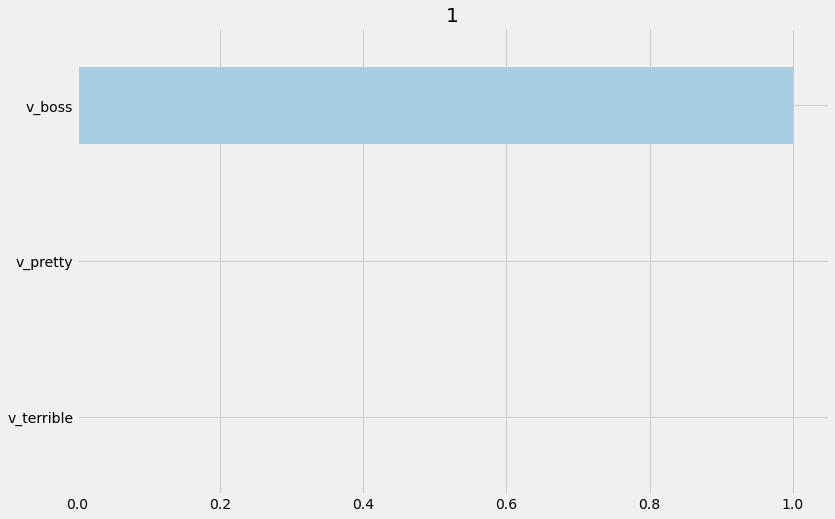

In [ ]:
cm.interpret(plot=True, method='feature_importance')

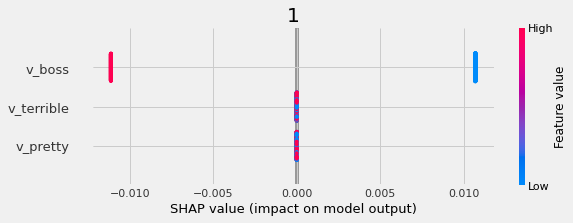

In [ ]:
cm.interpret(plot=True, method='shap_values')

### Causal Inference With Text as a Treatment

Suppose we were interested in estimating the causal impact of **sentiment** on the outcome.  That is, **sentiment** of text is the treatment, and the **gender** is a potential confounder. As we did above, we can use the `Autocoder` to create the treatment variable.  The only difference is that we would supply the `binarize=True` as an argument.

In [ ]:
df = ac.code_sentiment(original_df['Post_Text'].values, original_df, binarize=True, batch_size=16)

In [ ]:
df.head()

,Is_Male?,Post_Text,Post_Shared?,negative,positive
0,0,I really love my job!,0,0,1
1,0,I really love my job!,0,0,1
2,0,I really love my job!,0,0,1
3,0,I really love my job!,0,0,1
4,0,I really love my job!,0,0,1


In [ ]:
cm = CausalInferenceModel(df, metalearner_type='t-learner',
                          treatment_col='positive', outcome_col='Post_Shared?',
                          include_cols=['Is_Male?'])
cm.fit()

outcome column (categorical): Post_Shared?
treatment column: positive
numerical/categorical covariates: ['Is_Male?']
preprocess time:  0.00872349739074707  sec
start fitting causal inference model
time to fit causal inference model:  0.16087937355041504  sec


In [ ]:
ate = cm.estimate_ate()
ate

{'ate': 0.19008080596986368}

In [ ]:
assert ate['ate'] > 0.18
assert ate['ate'] < 0.2

In [ ]:
cm.get_required_columns()

['positive', 'Is_Male?']

In [ ]:
test_df = pd.DataFrame({
    'Is_Male?' : [1],
    'positive' : [1]
      })
effect = cm.predict(test_df)
print(effect)

[[0.20099539]]


In [ ]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_causalinference.ipynb.
Converted 01_autocoder.ipynb.
Converted 02_analyzers.ipynb.
Converted 03_preprocessing.ipynb.
Converted 99_examples.ipynb.
Converted index.ipynb.
